# Portafolios de Inversión
## Repaso Práctico
José Armando Melchor Soto

---





### Librerías 

In [1]:
import pandas as pd 
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize 

---

#### Funciones

##### Función Mínima Varianza 

In [2]:
def opt_min_var(rets):
    
    cov=rets.cov()
    n_assets = len(rets.columns)
    
    var = lambda w: w.T @ cov @ w
    
    w0=np.ones(n_assets)/n_assets
    
    bounds=[(0, 1)]*n_assets
    
    constraint=lambda w: sum(w)-1
    
    result=minimize(fun=var, x0=w0, bounds=bounds, constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)
    
    return result.x

##### Función Máximo de Sharpe

In [3]:
def opt_max_sharpe(rets, rf):
    
    E=rets.mean()
    cov=rets.cov()
    n_assets = len(rets.columns)
    
    rs = lambda w: -((w.T @ E - rf/252) / np.sqrt(w.T @ cov @ w))
    
    w0=np.ones(n_assets)/n_assets
    
    bounds=[(0, 1)]*n_assets
    
    constraint=lambda w: sum(w)-1
    
    result=minimize(fun=rs, x0=w0, bounds=bounds, constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)
    
    return result.x

##### Función Semi-Varianza Target

In [4]:
def objetivo (rets:pd.DataFrame , rets_b : pd.DataFrame ,corr:pd.DataFrame):
    
    rets, rets_b = rets.align(rets_b, join='inner', axis=0)
    diffs=rets - rets_b.values
    rends_below_bench = diffs[diffs < 0].fillna(0)
    target_downside_risk=np.array(rends_below_bench.std())
    target_semivarmatrix= corr * (target_downside_risk.reshape(len(rets.columns), 1) @ target_downside_risk.reshape(1, len(rets.columns)))

    objectivo = lambda w: (w.T @ target_semivarmatrix @ w)

    n = len(rets.keys())
    w_inicial = np.ones(n)/n
    bounds = [(0,1)]*n
    tol = 1e-9
    rest = lambda w: np.sum(w) - 1
    
    obj = minimize(
    fun=objectivo,
    x0=w_inicial,
    bounds=bounds,
    constraints={'fun': rest, 'type': 'eq'},
    tol=tol)

    w_objetivo = obj.x

    return dict(zip(rets.columns, w_objetivo))

##### Función Backtesting 

In [5]:
def backtesting(prices: pd.DataFrame, benchmark: pd.DataFrame, weights: dict, capital: float):
    
    rets_assets = prices.pct_change().dropna()
    rets_benchmark = benchmark.pct_change().dropna()
    
    
    df = pd.DataFrame(index=rets_assets.index)
    
    
    for strategy in weights.keys():
        if strategy == 'Benchmark':
            temp = rets_benchmark + 1
            temp.iloc[0]=capital
            temp = temp.cumprod()
            df[strategy] = temp.values            
    
        else:
            temp = (rets_assets * weights.get(strategy)).sum(axis=1)+1
            temp.iloc[0]=capital
            temp = temp.cumprod()
            df[strategy] = temp.values    

    plt.figure(figsize=(12,6))
    plt.plot(df, label=df.keys())
    plt.title('Backtesting of Strategies')
    plt.xlabel('Date')
    plt.ylabel('Portafolio Value')
    plt.legend()
    plt.show()


    return df

##### Función Métricas de Desempeño 

In [6]:
def metricas_anuales(history, rf):
    # Returns
    rets= history.pct_change().dropna()
    
    # Matriz de Cov
    cov_hist = rets.cov()

    # Dataframe
    metricas = pd.DataFrame(index=rets.columns)

    # Rendimiento 
    metricas['Rendimiento Promedio Anual'] = R_p = rets.mean()*252*100
    
    # Volatilidad 
    metricas['Volatilidad Anual'] = vol_anual = rets.std()*np.sqrt(252)*100
    
    # Ratio de Sharpe
    metricas['Ratio de Sharpe'] = (R_p - rf) / vol_anual

    # Downside Risk
    metricas['Downside Risk'] = downside = rets[rets < 0].std() * np.sqrt(252) * 100

    # Upside Risk
    metricas['Upside Risk'] = upside = rets[rets > 0].std() * np.sqrt(252) * 100

    # Omega
    metricas['Omega'] =omega= upside / downside

    # Beta

    covs = cov_hist['Benchmark']
    varianza_market = covs['Benchmark']
    metricas['Beta'] = beta = covs / varianza_market

    # Alfa de Jensen

    R_m = rets['Benchmark']
    alpha_Jensen = R_p - (rf + beta * (R_m - rf))

    # Ratio de Treynor
    metricas['Ratio de Treynor'] = (R_p - rf) / beta

    # Ratio de Sortino
    metricas['Ratio de Sortino'] = (R_p - rf) / downside

    return metricas.T


---

#### Importación de los datos 

In [7]:
tickers= ['GOOGL', 'AAPL', 'MSFT', 'META', 'LLY']

In [ ]:
opt_prices = yf.download(tickers, start='2016-01-02', end='2020-03-27',progress= False)['Close']

bt_prices = yf.download(tickers, start='2020-01-02', end='2024-03-27', progress= False)['Close']

benchmark = yf.download(['^GSPC'], start='2020-01-02', end='2024-03-27', progress= False)['Close']


YF.download() has changed argument auto_adjust default to True


---

#### Returns 

In [9]:
### Returns 
opt_rets = opt_prices.pct_change().dropna()

In [10]:
### Returns Benchmark
bt_rets = benchmark.pct_change().dropna()

#### Matriz de Corr


In [11]:
corr = opt_rets.corr()
corr

Ticker,AAPL,GOOGL,LLY,META,MSFT
Ticker,,,,,
AAPL,1.000000,0.670259,0.415042,0.548601,0.708326
GOOGL,0.670259,1.000000,0.409210,0.685496,0.782666
LLY,0.415042,0.409210,1.000000,0.306682,0.477186
META,0.548601,0.685496,0.306682,1.000000,0.622400
MSFT,0.708326,0.782666,0.477186,0.622400,1.000000


---

#### Mínima Varianza 

In [13]:
min_var = opt_min_var(opt_rets)
min_var

array([1.10464918e-01, 3.21082491e-01, 4.84182887e-01, 8.42697038e-02,
       1.25360876e-19])

#### Maximo Sharpe

In [15]:
max_sharpe = opt_max_sharpe(opt_rets, rf=0.045)
max_sharpe

array([0.18788795, 0.        , 0.04024915, 0.        , 0.7718629 ])

#### Semivarianza target

In [16]:
semivar_target = objetivo ( opt_rets, bt_rets, corr)
semivar_target

{'AAPL': 0.41333999161706125,
 'GOOGL': 0.2526476249804109,
 'LLY': 0.02360815099206437,
 'META': 1.3877787807814457e-17,
 'MSFT': 0.31040423241046355}

#### Backtesting

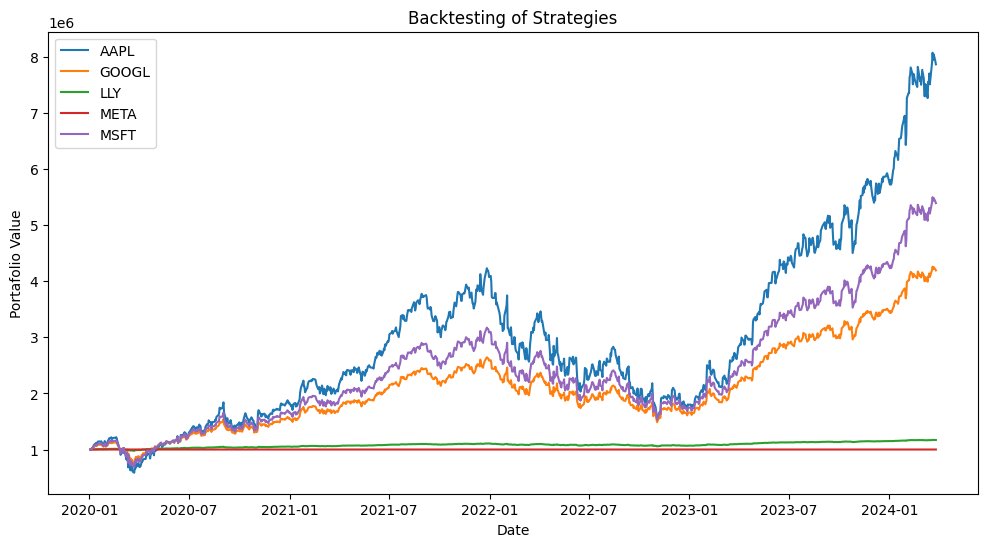

In [17]:
history = backtesting (bt_prices , benchmark , semivar_target, 1000000)

#### Metricas de desempeño

In [18]:
metricas_anuales = metricas_anuales(history, rf=0.045)

KeyError: 'Benchmark'